# Mitchell Pudil
## Econ 213R: Applied Machine Learning
## Homework 2: Kaggle House Prices

In [1]:
from IPython.display import HTML
HTML('<img src="http://www.clevver.com/wp-content/uploads/2014/04/office-michael-scott-declare-bankruptcy.gif">')


## We will begin by importing the appropriate packages that will be used later to analyze data

In [2]:
import pandas as pd # Allows to type pd to represent pandas 
import numpy as np # Allows for scientific computing
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # Allows for cleaner graphing capabilities

# Machine learning packages

from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder

# Don't show warnings (for presentation purposes)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


## Drop ID and sales price and save them somewhere else.

In [3]:
train = pd.read_csv("/Users/mitchellpudil/Desktop/all/train.csv")  # Import dataset from csv
test = pd.read_csv("/Users/mitchellpudil/Desktop/all/test.csv")  # Import dataset from csv

train_id = train['Id']
train = train.drop(['Id'], axis=1)

test_Id = test['Id']
test.drop("Id", axis = 1, inplace = True)


In [4]:
train.columns   # Look at columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Text(0.5,1,'Sale Price Distribution')

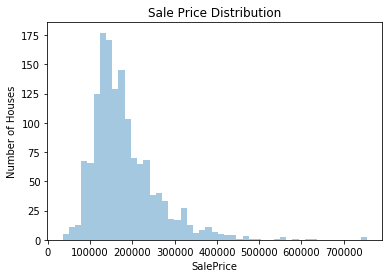

In [5]:
sns.distplot(train.SalePrice, kde=False) #kde is kernel density estimate
plt.ylabel('Number of Houses')
plt.title('Sale Price Distribution')


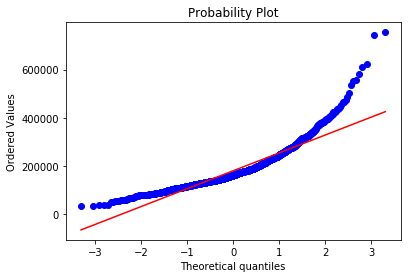

In [6]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

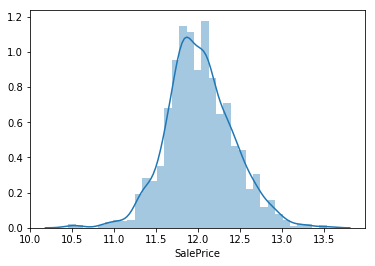

In [7]:
train['SalePrice'] = np.log(train['SalePrice'])   # Define logsale as log of sale price
sns.distplot(train['SalePrice'])   # Graph log of sale price



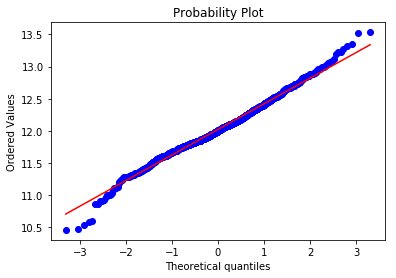

In [8]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Sale price is now normally distributed

In [9]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)].index) # Dropping outliers, where
# square footage is greater than 4000 and sale price is less than 300,000

## Let's take a look at missing data

Text(0.5,1,'Percent missing data by feature')

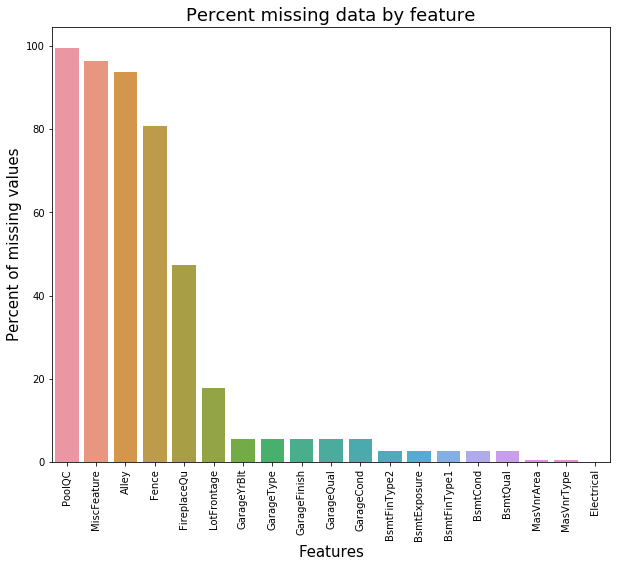

In [10]:
#Calculate missing data
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(30)

#Graph missing data as histogram
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=18)

# Code for missing data graph by KartikeDutta


### Let's Look at Correlations of the Variables


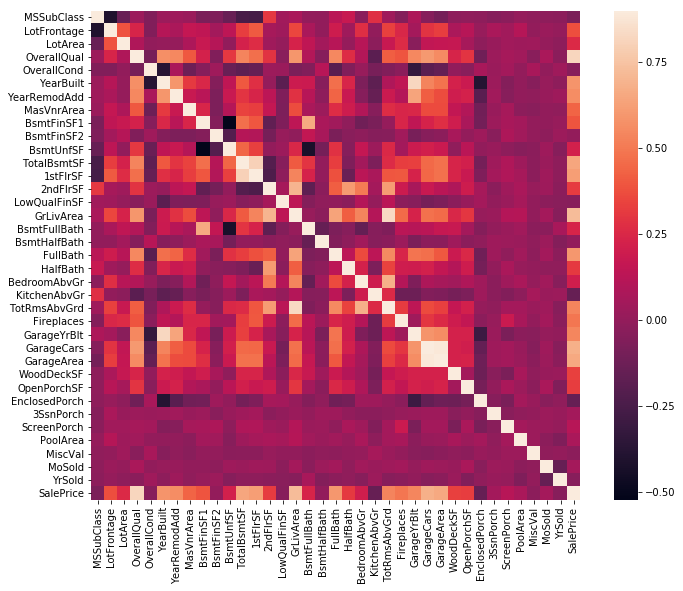

In [11]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Remember that pool quality and pool area have already been taken care of by renaming. Note also that Misc Feature refers to things like an elevator, 2nd garage, shed, tennis court, etc. An Na for an alley just means that there was no alley, so we'll fix that too. Same thing for fence, fireplace, garage type/finish/quality, basement quality. However, for lot frontage, we will need to replace some missing variables. This takes care of most of the problems related to missing values.



In [12]:
train_na.head(20)

PoolQC         99.588
MiscFeature    96.296
Alley          93.759
Fence          80.727
FireplaceQu    47.325
LotFrontage    17.764
GarageYrBlt     5.556
GarageType      5.556
GarageFinish    5.556
GarageQual      5.556
GarageCond      5.556
BsmtFinType2    2.606
BsmtExposure    2.606
BsmtFinType1    2.538
BsmtCond        2.538
BsmtQual        2.538
MasVnrArea      0.549
MasVnrType      0.549
Electrical      0.069
dtype: float64

### Since lot frontage is highly correlated with the type of neighborhood it is in, we will replace it by the median in the neighborhood category. Briefly, the variables I chose to fill in as 'None' are that because they were marked, but there was no corresponding appliance or feature of that house (garage, fireplace, etc.). The features I chose to fill in as a 0 I did because they were numericals that were missing. Those that I filled in as 'mode' were missing categoricals.

In [13]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [14]:

#Replace necessary missing data with "None"
for col in ('FireplaceQu','PoolArea','PoolQC', 'MiscFeature', 'Alley', 'Fence', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'MasVnrArea'):
    train[col] = train[col].fillna('None')

#Replace necessary missing data with "None"
for col in ('GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'MasVnrArea'):
    train[col] = train[col].fillna(0)
    
#Replace necessasry missing data with mode    
for col in ('Electrical', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'MasVnrType', 'MasVnrArea', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'): 
    train[col] = train[col].fillna(train[col].mode()[0]) 

In [15]:
# Recalculate missing data to make sure no variables were left out
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(30)

,Missing Ratio


### There are now no missing data

## Let's now look at skewness

In [16]:
num_feat = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[num_feat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print('There are {} variables to transform'.format(skewness.shape[0]))



Skew in numerical features: 

There are 35 variables to transform


### Box Cox transform data (For some reason, this ends up getting me worse estimates, so I'm leaving it out for now)

In [17]:
#from scipy.special import boxcox1p
#lmbda = .15  # Hyperperameter to change around

#for var in skewness.index:
#    train[var] = boxcox1p(train[var], lmbda)

## Feature Engineering

### Add a feature for the total square footage of the houses 

In [18]:
train['TotalSqFt'] = train['LotArea'] + train['GrLivArea'] + train['GarageArea']+ train['1stFlrSF'] + train['TotalBsmtSF'] + train['BsmtUnfSF'] + train['LotFrontage'] + train['OpenPorchSF'] + train['2ndFlrSF'] + train['WoodDeckSF']

## Outliers

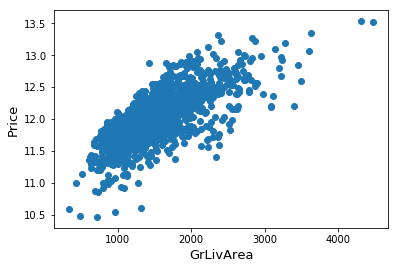

In [19]:
## Create a function for this plot since we will be using it again after we get rid of the outliers.
def plot_sqft_outlier(sqft_measure):
    fig, ax = plt.subplots()
    ax.scatter(x = train[sqft_measure], y = train['SalePrice'])
    plt.ylabel('Price', fontsize=13)
    plt.xlabel(sqft_measure, fontsize=13)
    plt.show()


plot_sqft_outlier('GrLivArea')

### Plot again to make sure it got rid of the outlier

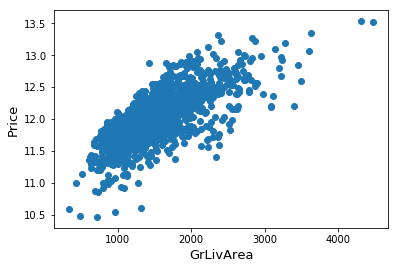

In [20]:
 plot_sqft_outlier('GrLivArea')

### Before, we looked at outliers with just one of the square footage measurements. Let's do this same thing but with total square footage.

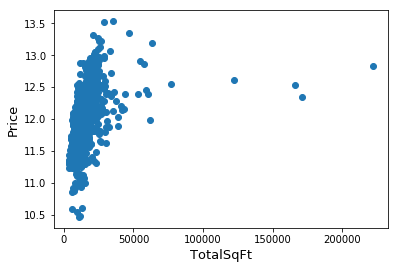

In [21]:
plot_sqft_outlier('TotalSqFt')

#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)].index) # Dropping outliers, where
# square footage is greater than 4000 and sale price is less than 300,000

In [22]:
train = train.drop(train[(train['TotalSqFt']>60000) & (train['SalePrice']<13.1)].index) # Dropping outliers

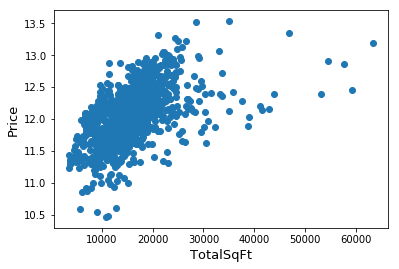

In [23]:
plot_sqft_outlier('TotalSqFt') 

### Just to cover all our bases with these types of outliers, let's look at the other types of square footage against Price (or at least the ones that showed up in the most important variables list that will be shown later on).

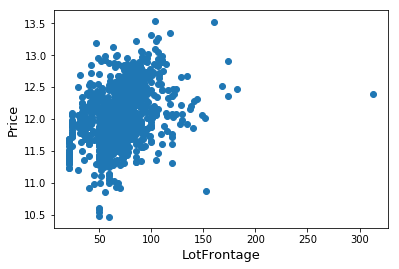

In [24]:
plot_sqft_outlier('LotFrontage')


In [25]:
train = train.drop(train[(train['LotFrontage']>250) & (train['SalePrice']<13)].index) # Dropping outliers 

### Just to save on space, I'm not going to show the plots of the features footage vs price, but I have looked through the rest and the code will get rid of the rest of the other outliers :) 

In [26]:
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<12.5)].index) # Dropping outliers 
train = train.drop(train[(train['LotArea']>35000) & (train['SalePrice']>12)].index)
train = train.drop(train[(train['OpenPorchSF']>450)].index)
train = train.drop(train[(train['EnclosedPorch']>500)].index)

### Since the test and train dataset do not have the same dimensionality, we will need to subset the training dataset to only the columns included in both, and then sort the columns alphabetically, so that they have the same order

In [27]:
Price=train['SalePrice']
train = train.drop(['SalePrice'], axis=1)  # Get rid of Sale Price variable since that is our target


## Getting dummy variables for all objects so we can scale and make use of categorical variables

### And speaking of dummies...

In [28]:
HTML('<img src="https://media.giphy.com/media/10uoxQhDburBiE/giphy.gif">')

In [29]:
object_columns = train.select_dtypes(include=['object']).columns
train=pd.get_dummies(train, columns=object_columns)

## Scaling Features

In [30]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_train_df = pd.DataFrame(scaler.fit_transform(train))
scaled_train_df.columns = train.columns

In [31]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Cleaning Testing Dataset

In [32]:
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


for col in ('FireplaceQu','PoolArea','PoolQC', 'MiscFeature', 'Alley', 'Fence', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'MasVnrArea'):
    test[col] = test[col].fillna('None')
    
for col in ('GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'MasVnrArea'):
    test[col] = test[col].fillna(0)
    
for col in ('Electrical', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'MasVnrType', 'MasVnrArea', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'): 
    test[col] = test[col].fillna(test[col].mode()[0]) 
    
test['TotalSqFt'] = test['LotArea'] + test['GrLivArea'] + test['GarageArea']+ test['1stFlrSF'] + test['TotalBsmtSF'] + test['BsmtUnfSF'] + test['LotFrontage'] + test['OpenPorchSF'] + test['OpenPorchSF'] + test['2ndFlrSF'] + test['WoodDeckSF']


    
num_feat = test.dtypes[test.dtypes != "object"].index

# Skewness
#skewed_feats = test[num_feat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
#skewness = pd.DataFrame({'Skew' :skewed_feats})
#skewness = skewness[abs(skewness) > 0.75]

#lmbda = .15 

#for var in skewness.index:
 #   test[var] = boxcox1p(test[var], lmbda)
    

object_columns = test.select_dtypes(include=['object']).columns
test=pd.get_dummies(test, columns=object_columns)

# Scaling

scaled_test_df = pd.DataFrame(scaler.fit_transform(test))
scaled_test_df.columns = test.columns

### We need to make sure that the train and test data sets have the same columns so we can use the trained model on the test data set. To do this, I took the intersection of the two data frames (scaled train and scaled test) and found the columns they had in common.

In [33]:
cols_in_comm = np.intersect1d(scaled_train_df.columns, scaled_test_df.columns)  # Intersecting to find columns in common
scaled_train_df = scaled_train_df[cols_in_comm]    # Subsetting the train dataset to include only the columns in common
scaled_test_df = scaled_test_df[cols_in_comm]  # Doing the same to the training data set

# Reindexing the new training and test datasets to be in order so that the models put correct weights on the different features.
scaled_train_df = scaled_train_df.reindex(sorted(scaled_train_df.columns), axis=1)  
scaled_test_df = scaled_test_df.reindex(sorted(scaled_test_df.columns), axis=1)

print(scaled_train_df.shape, scaled_test_df.shape)

(1434, 560) (1459, 560)


# Modelling with training set

### Now that we have the same number of columns in the training and test data set, we can move forward with our modelling.

## Train test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train_df, Price, test_size=.20, random_state=42)

### First import some useful packages for modelling

In [35]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
from sklearn import datasets, linear_model

### Function of graph to determine how bias changes as we increase sample size for a given model

In [36]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html (and from Tyler Folkman)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [37]:
def give_rsme(model):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))
#def gridsearching(model, parameters):
#    gridsearch = GridSearchCV(model(), parameters)
#    print("Best Params: {}".format(gridsearch.best_params_))
#    give_rsme(gridsearch)
#    

def gridsearching(model, parameters):
    gridsearch = GridSearchCV(model(), parameters)
    gridsearch.fit(X_train, y_train)
    print("Best Params: {}".format(gridsearch.best_params_))
    y_pred_train = gridsearch.predict(X_train)
    y_pred_test = gridsearch.predict(X_test)
    print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                          mean_squared_error(y_test, y_pred_test)))


In [38]:
scaled_test_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley_Grvl,Alley_None,Alley_Pave,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,TotalSqFt,Utilities_AllPub,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.655,-0.775,-0.089,-0.224,0.281,-0.161,-1.030,0.459,-0.147,-0.202,...,-0.064,0.064,-0.918,-0.368,0.069,0.000,0.367,-0.341,-1.073,1.714
1,0.433,-0.775,-0.089,-0.224,0.281,-0.161,0.176,0.459,-0.147,-0.202,...,-0.064,0.064,-0.255,0.640,0.759,0.000,2.348,-0.440,-1.215,1.714
2,-0.574,0.892,-0.089,-0.224,0.281,-0.161,0.176,0.459,-0.147,-0.202,...,-0.064,0.064,-0.255,-0.265,0.668,0.000,0.930,0.844,0.679,1.714
3,-0.579,0.837,-0.089,-0.224,0.281,-0.161,0.176,0.459,-0.147,-0.202,...,-0.064,0.064,0.408,-0.269,0.051,0.000,2.089,0.877,0.679,1.714
4,0.310,-0.775,-0.089,-0.224,0.281,-0.161,-1.030,-2.178,-0.147,-0.202,...,-0.064,0.064,-0.918,0.529,-0.784,0.000,-0.730,0.679,0.395,1.714


In [39]:
scaled_train_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley_Grvl,Alley_None,Alley_Pave,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,TotalSqFt,Utilities_AllPub,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.803,1.181,-0.117,-0.188,0.259,-0.172,0.170,0.446,-0.144,-0.194,...,-0.046,0.046,0.935,-0.462,-0.289,0.026,-0.759,1.047,0.879,0.137
1,0.298,-0.797,-0.117,-0.188,0.259,-0.172,0.170,0.446,-0.144,-0.194,...,-0.046,0.046,-0.310,0.523,-0.093,0.026,1.699,0.152,-0.429,-0.615
2,-0.629,1.209,-0.117,-0.188,0.259,-0.172,0.170,0.446,-0.144,-0.194,...,-0.046,0.046,-0.310,-0.307,0.396,0.026,-0.759,0.981,0.831,0.137
3,-0.518,0.954,-0.117,-0.188,0.259,-0.172,0.170,0.446,-0.144,-0.194,...,-0.046,0.046,0.313,-0.704,0.012,0.026,-0.759,-1.872,-0.720,-1.367
4,-0.019,1.642,-0.117,-0.188,0.259,-0.172,1.405,0.446,-0.144,-0.194,...,-0.046,0.046,1.558,0.239,1.338,0.026,0.825,0.948,0.734,0.137


## Use Gradient Boost to determine best features

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=12, min_samples_split=10, 
                                   loss='huber', random_state =5)
give_rsme(GBoost)

Train MSE: 0.002377308944369627	Test MSE: 0.016900254084209598


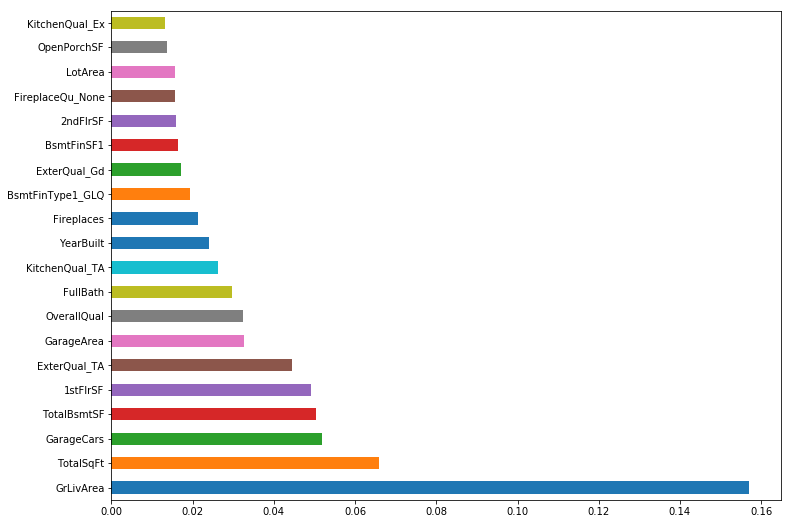

In [41]:
feat_importances = pd.Series(GBoost.feature_importances_, index=scaled_test_df.columns)   #Finding most important features
plt.subplots(figsize=(12,9))
feat_importances.nlargest(20).plot(kind='barh')    # Graphing best features along with their weight of importance

## Code for making this graph from KartikeDutta

### That graph was almost as colorful as...

In [42]:
HTML('<img src="https://media.tenor.com/images/716de2ca8f9bffa41358f2df77c3b669/tenor.gif">')

### Let's see how big of an impact using only the top 100 features made in reducing overfiting (keep it at a 1:15 predictors:observations ratio

In [43]:
best_features = list(pd.DataFrame(feat_importances.nlargest(100)).index)
scaled_train_df2 = scaled_train_df[best_features]
scaled_test_df2 = scaled_test_df[best_features]

X_train, X_test, y_train, y_test = train_test_split(scaled_train_df2, Price, test_size=.20, random_state=12)


In [44]:
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=12, min_samples_split=10, 
                                   loss='huber', random_state =5)
give_rsme(GBoost)

Train MSE: 0.005183862959103268	Test MSE: 0.010222067568739878


### SGD

In [45]:
SGD = SGDRegressor(tol=.0001, eta0=.0025)  # Define SGD using the parameters defined through the SGD Regressor

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

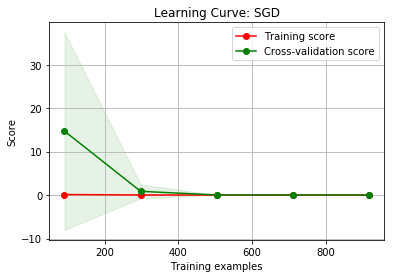

In [46]:
plot_learning_curve(SGD, "Learning Curve: SGD", X_train, y_train, cv=5)

### Lasso

In [47]:
gridsearching(linear_model.Lasso, {"alpha": [0.001,0.0025, 0.005, 0.01, 0.025,0.005]})

Best Params: {'alpha': 0.0025}
Train MSE: 0.011230077047977552	Test MSE: 0.010618790660350564


In [48]:
lasso = linear_model.Lasso(alpha=0.0025)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

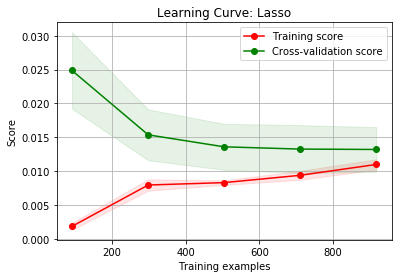

In [49]:
plot_learning_curve(lasso, "Learning Curve: Lasso", X_train, y_train, cv=5)

### Elastic Net

In [50]:
gridsearching(linear_model.ElasticNet,{"alpha": [0.001,.0025,0.005, .1, .3, .5]})

Best Params: {'alpha': 0.005}
Train MSE: 0.01123218625959922	Test MSE: 0.010621178237527602


In [51]:
ENet = linear_model.ElasticNet(alpha=0.005)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

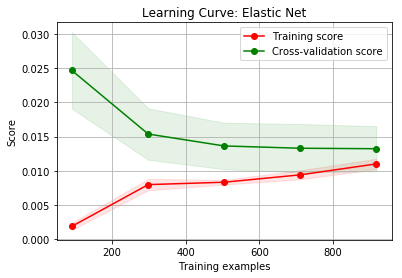

In [52]:
plot_learning_curve(ENet, "Learning Curve: Elastic Net", X_train, y_train, cv=5)

### Kernel Ridge

In [53]:
gridsearching(KernelRidge, {"alpha": [0.01,0.05,0.1,0.5,1,2,5], 'kernel': ['polynomial'], 
              'degree': [2,3,4,5], 'coef0': [2,2.5,3,3.5,4]})

Best Params: {'alpha': 5, 'coef0': 4, 'degree': 2, 'kernel': 'polynomial'}
Train MSE: 0.007671599650822328	Test MSE: 0.009792343235793121


In [54]:
kridge=KernelRidge(alpha=5, kernel='polynomial', degree=2, coef0=4)
give_rsme(kridge)

Train MSE: 0.007671599650822328	Test MSE: 0.009792343235793121


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

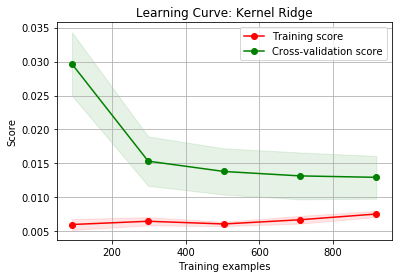

In [55]:
plot_learning_curve(kridge, "Learning Curve: Kernel Ridge", X_train, y_train, cv=5)

### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

gridsearching(RandomForestRegressor, {'n_estimators': [50,100,200], 'min_samples_leaf': [3,5,10,15]})

Best Params: {'min_samples_leaf': 3, 'n_estimators': 200}
Train MSE: 0.005539519130029873	Test MSE: 0.014092076144917153


In [57]:
rforest = RandomForestClassifier(n_estimators=200, min_samples_leaf=3)

### K Nearest Neighbors

In [58]:
kneighbors = KNeighborsRegressor(n_neighbors=5, p=2, weights='distance')
give_rsme(kneighbors)

Train MSE: 0.0	Test MSE: 0.022615016204107084


# Submissions to Kaggle! 
## Out of the models I tested, Elastic Net, Kernel Ridge, and Gradient Boost that had a low test RSME

In [59]:
def submit(model):
    model.fit(X_train, y_train)
    sub = pd.DataFrame()
    sub['Id'] = test_Id
    y_pred = np.exp(model.predict(scaled_test_df2))
    sub['SalePrice'] = y_pred
    sub.to_csv('submission_'+str(model)[0:7]+'.csv', index=False)


# Submission for Elastic Net
## The beeessstt model

In [60]:
HTML('<img src="https://media.giphy.com/media/rcqxcl5DGhM9q/giphy.gif">')

In [61]:
#submit(ENet)

## Submission for GBoost

In [62]:
#submit(GBoost)

## Submission for Kernel Ridge

In [63]:
#submit(kridge)

### Averaging y predictions from GBoost and elastic net (makeshift ensemble)

In [64]:
def averaging(model):
    model.fit(X_train, y_train)
    sub = pd.DataFrame()
    sub['Id'] = test_Id
    y_pred = np.exp(model.predict(scaled_test_df2))
    sub['SalePrice'] = y_pred
    return y_pred

y_pred_averages = 0.5*averaging(GBoost) + 0.5*averaging(ENet)

sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = y_pred_averages
#sub.to_csv('averages4', index=False)


# My personal Kaggle Record so far (using elastic net):

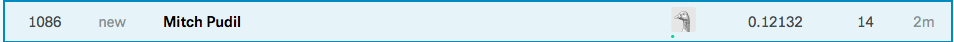

In [65]:
from IPython.display import display
from PIL import Image
path="/Users/mitchellpudil/Desktop/score.png"
display(Image.open(path))

In [66]:
HTML('<img src="https://media1.tenor.com/images/1dd03671ab0311a6ec446dd1ce4d91a9/tenor.gif?itemid=6103373">')